## Zero-shot prediction of *BRCA1* variant effects with Evo 2

The human *BRCA1* gene encodes for a protein that repairs damaged DNA ([Moynahan et al., 1999](https://www.cell.com/molecular-cell/fulltext/S1097-2765%2800%2980202-6)). Certain variants of this gene have been associated with an increased risk of breast and ovarian cancers ([Miki et al., 1994](https://www.science.org/doi/10.1126/science.7545954?url_ver=Z39.88-2003&rfr_id=ori:rid:crossref.org&rfr_dat=cr_pub%20%200pubmed)). Using Evo 2, we can predict whether a particular single nucleotide variant (SNV) of the *BRCA1* gene is likely to be harmful to the protein's function, and thus potentially increase the risk of cancer for the patient with the genetic variant.

We start by loading a dataset from [Findlay et al. (2018)](https://www.nature.com/articles/s41586-018-0461-z), which contains experimentally measured function scores of 3,893 *BRCA1* SNVs. These function scores reflect the extent by which the genetic variant has disrupted the protein's function, with lower scores indicating greater disruption. In this dataset, the SNVs are classified into three categories based on their function scores: `LOF` (loss-of-function), `INT` (intermediate), and `FUNC` (functional). We start by reading in this dataset.

### Setup imports

In [1]:
from Bio import SeqIO, Seq
import gzip
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
from sklearn.metrics import roc_auc_score
import io
import base64

import numpy as np
import requests
from tqdm import tqdm

from concurrent.futures import ThreadPoolExecutor, as_completed
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

# Set root path
os.chdir('../..')

### Load API and define functions to use it

In [11]:
NVIDIA_API_KEY = os.getenv("NVCF_RUN_KEY") or os.getenv("NVIDIA_API_KEY")
BASE_URL = "https://health.api.nvidia.com/v1/biology"

if NVIDIA_API_KEY is None:
    raise RuntimeError(
        "Missing NVIDIA API key. Set env var NVCF_RUN_KEY or NVIDIA_API_KEY."
    )

# Create a session
session = requests.Session()
adapter = HTTPAdapter(
    pool_connections=32, pool_maxsize=32,
    max_retries=Retry(total=3, backoff_factor=0.3, status_forcelist=[429, 500, 502, 503, 504])
)
session.mount("https://", adapter)

# Add default headers (applied automatically to every request)
session.headers.update({
    "Authorization": f"Bearer {NVIDIA_API_KEY}",
    "Content-Type": "application/json",
})


def evo2_generate(
    sequence,
    num_tokens=100,
    temperature=0.7,
    top_k=1,
    top_p=0.0,
    seed=None,
    enable_sampled_probs=False,
    enable_logits=False,
    model="evo2-7b"
):
    """Call Evo2 / generate to extend a DNA seed."""
    payload = {
        "sequence": sequence,
        "num_tokens": int(num_tokens),
        "temperature": float(temperature),
        "top_k": int(top_k),
        "top_p": float(top_p),
        "enable_sampled_probs": bool(enable_sampled_probs),
        "enable_elapsed_ms_per_token": False,
        "enable_logits": bool(enable_logits),
    }
    if seed is not None:
        payload["random_seed"] = int(seed)

    url = f"{BASE_URL}/arc/{model}/generate"
    r = session.post(url, json=payload, timeout=120)
    r.raise_for_status()
    return r.json()

def evo2_forward(sequence, output_layers=None, model="evo2-7b"):
    """
    Call Evo2 /forward to get layer outputs (embeddings/logits) as base64 NPZ. (numpy zip format)
    Returns a dict-like {layer_name: np.ndarray}.
    """
    if output_layers is None:
        # 'unembed' is typically the final pre-softmax logits
        output_layers = ["unembed"]

    payload = {
        "sequence": sequence,
        "output_layers": output_layers
    }

    url = f"{BASE_URL}/arc/{model}/forward"
    r = session.post(url, json=payload, timeout=300)
    r.raise_for_status()
    # parse the output
    blob = r.json()["data"]  # base64-encoded NPZ
    npz = np.load(io.BytesIO(base64.b64decode(blob)))
    return {k: npz[k] for k in npz.files}


# Test the generate API
seed_seq = "TTCCGGTTCC"
out = evo2_generate(seed_seq, model="evo2-40b", num_tokens=20, seed=123, enable_sampled_probs=True, enable_logits=True)
print("Generated sequence:", out["sequence"])

# Test the forward API
out = evo2_forward(seed_seq)
# Inspect each layer’s embedding shape
for name, arr in out.items():
    print(f"{name} shape = {arr.shape}")
    print(f"First few values: {arr.flatten()[:5]}\n")

Generated sequence: TGAAAAAATATTTTTTTTTT
unembed.output shape = (1, 10, 512)
First few values: [-10.125 -22.875 -22.875 -22.875 -22.875]



### Load data and preprocess

In [3]:
brca1_df = pd.read_excel(
    os.path.join('notebooks', 'brca1', '41586_2018_461_MOESM3_ESM.xlsx'),
    header=2,
)
brca1_df = brca1_df[[
    'chromosome', 'position (hg19)', 'reference', 'alt', 'function.score.mean', 'func.class',
]]

brca1_df.head(10)

,chromosome,position (hg19),reference,alt,function.score.mean,func.class
0,17,41276135,T,G,-0.372611,FUNC
1,17,41276135,T,C,-0.045313,FUNC
2,17,41276135,T,A,-0.108254,FUNC
3,17,41276134,T,G,-0.277963,FUNC
4,17,41276134,T,C,-0.388414,FUNC
5,17,41276134,T,A,-0.280973,FUNC
6,17,41276133,C,T,-0.973683,INT
7,17,41276133,C,G,-0.373489,FUNC
8,17,41276133,C,A,0.006314,FUNC
9,17,41276132,A,T,-0.207552,FUNC


We then group the `FUNC` and `INT` classes of SNVs together into a single category (`FUNC/INT`).

In [4]:
# Rename columns
brca1_df.rename(columns={
    'chromosome': 'chrom',
    'position (hg19)': 'pos',
    'reference': 'ref',
    'alt': 'alt',
    'function.score.mean': 'score',
    'func.class': 'class',
}, inplace=True)

# Convert to two-class system
brca1_df['class'] = brca1_df['class'].replace(['FUNC', 'INT'], 'FUNC/INT')

brca1_df.head(10)

,chrom,pos,ref,alt,score,class
0,17,41276135,T,G,-0.372611,FUNC/INT
1,17,41276135,T,C,-0.045313,FUNC/INT
2,17,41276135,T,A,-0.108254,FUNC/INT
3,17,41276134,T,G,-0.277963,FUNC/INT
4,17,41276134,T,C,-0.388414,FUNC/INT
5,17,41276134,T,A,-0.280973,FUNC/INT
6,17,41276133,C,T,-0.973683,FUNC/INT
7,17,41276133,C,G,-0.373489,FUNC/INT
8,17,41276133,C,A,0.006314,FUNC/INT
9,17,41276132,A,T,-0.207552,FUNC/INT


Check the number of each type of mutation (Loss of function or not).

In [5]:
# print the class distribution
brca1_df['class'].value_counts()

class
FUNC/INT    3070
LOF          823
Name: count, dtype: int64

We build a function to parse the reference and variant sequences of a 8,192-bp window around the genomic position of each SNV, using the reference sequence of human chromosome 17 where *BRCA1* is located.

In [6]:
WINDOW_SIZE = 8192

# Read the reference genome sequence of chromosome 17
with gzip.open(os.path.join('notebooks', 'brca1', 'GRCh37.p13_chr17.fna.gz'), "rt") as handle:
    for record in SeqIO.parse(handle, "fasta"):
        seq_chr17 = str(record.seq)
        print(f'Chromosome 17 is loaded with length: {len(seq_chr17)} bp')
        break

# generate a reference sequence and a variant sequence given a position, reference nucleotide, and alternative nucleotide
def parse_sequences(seq, pos, ref, alt):
    """
    Parse reference and variant sequences from the reference genome sequence.
    """
    # the positions in the input file are 1-indexed, correct this by subtracting 1
    p = pos - 1 # Convert to 0-indexed position

    # Calculate the half window size to center the sequence around the SNV
    half_window = WINDOW_SIZE // 2

    # the first position of the reference sequence should be at least 0
    # the last position of the reference sequence should be at most the length of the chromosome sequence
    ref_seq_start = max(0, p - half_window)
    ref_seq_end = min(len(seq), p + half_window)

    # slice out the reference sequence
    ref_seq = seq_chr17[ref_seq_start:ref_seq_end]

    # Calculate the position of the SNV within the reference sequence
    snv_pos_in_ref = min(WINDOW_SIZE//2, p)
    var_seq = ref_seq[:snv_pos_in_ref] + alt + ref_seq[snv_pos_in_ref+1:]

    # Sanity checks
    assert len(var_seq) == len(ref_seq)
    assert ref_seq[snv_pos_in_ref] == ref
    assert var_seq[snv_pos_in_ref] == alt

    return ref_seq, var_seq

# Parse sequences for the first variant
row = brca1_df.iloc[0]
ref_seq, var_seq = parse_sequences(seq_chr17, row['pos'], row['ref'], row['alt'])

print(row)
print('--')
print(f'Reference, SNV 0: ...{ref_seq[4082:4112]}...')
print(f'Variant, SNV 0:   ...{var_seq[4082:4112]}...')

Chromosome 17 is loaded with length: 81195210 bp
chrom          17
pos      41276135
ref             T
alt             G
score   -0.372611
class    FUNC/INT
Name: 0, dtype: object
--
Reference, SNV 0: ...TGTTCCAATGAACTTTAACACATTAGAAAA...
Variant, SNV 0:   ...TGTTCCAATGAACTGTAACACATTAGAAAA...


In [7]:
# Build mappings of unique reference sequences
ref_seqs = []
ref_seq_to_index = {}

# Parse sequences and store indexes
ref_seq_indexes = []
var_seqs = []

# loop over the rows in the dataframe
for _, row in brca1_df.iterrows():

    # get the reference and variant sequences
    ref_seq, var_seq = parse_sequences(seq_chr17, row['pos'], row['ref'], row['alt'])

    # Get or create index for reference sequence (to avoid duplicates)
    if ref_seq not in ref_seq_to_index:
        ref_seq_to_index[ref_seq] = len(ref_seqs)
        ref_seqs.append(ref_seq)
    
    ref_seq_indexes.append(ref_seq_to_index[ref_seq])
    var_seqs.append(var_seq)

ref_seq_indexes = np.array(ref_seq_indexes)

In [8]:
# There are less unique reference sequences than total sequences because some variants share the same reference sequence
# AKA when the variants are at the same position
print(f'Number of unique reference sequences: {len(ref_seqs)}')
print(f'Number of variant sequences: {len(var_seqs)}')

Number of unique reference sequences: 1326
Number of variant sequences: 3893


### Remake the model.score_sequences function for the API version

In [16]:
def forward_logits(sequence, model="evo2-7b"):
    out = evo2_forward(sequence, model=model)
    print(out.keys())
    logits = out["unembed.output"]
    if logits.ndim == 3 and logits.shape[1] == 1:     # docs: [L, batch, 512]
        logits = logits[:, 0, :]                      # -> (L, 512)
    elif logits.ndim == 3 and logits.shape[0] == 1:   # some older builds: (1, L, 512)
        logits = logits[0]
    if logits.ndim != 2:
        raise RuntimeError(f"Expected logits shape (L, V), got {logits.shape}")
    return logits

def logits_to_log_softmax(logits):
    m = np.max(logits, axis=-1, keepdims=True)
    z = logits - m
    return z - np.log(np.sum(np.exp(z), axis=-1, keepdims=True))

def per_position_entropy_from_logits(logits):
    logp = logits_to_log_softmax(logits)
    p = np.exp(logp)
    return -np.sum(p * logp, axis=-1)

def gather_logprobs_for_sequence_tokens(log_probs, seq):
    token_ids = np.fromiter((ord(c) for c in seq), dtype=np.int64)
    L, V = log_probs.shape
    if len(token_ids) != L:
        raise ValueError(f"Sequence length {len(token_ids)} != logits length {L}")
    targets = token_ids[1:]
    return log_probs[:-1, :][np.arange(L - 1), targets]

def _sequence_loglik(seq, model="evo2-7b", reduce_method="mean"):
    logits = forward_logits(seq, model=model)
    log_probs = logits_to_log_softmax(logits)
    next_token_ll = gather_logprobs_for_sequence_tokens(log_probs, seq)
    return float(np.sum(next_token_ll) if reduce_method == "sum" else np.mean(next_token_ll))

def score_sequences_api_parallel(seqs, model="evo2-7b", reduce_method="mean", max_workers=8):
    scores = [None] * len(seqs)
    with ThreadPoolExecutor(max_workers=max_workers) as ex:
        futures = {ex.submit(_sequence_loglik, s, model, reduce_method): i for i, s in enumerate(seqs)}
        for fut in as_completed(futures):
            i = futures[fut]
            scores[i] = fut.result()
    return scores

def positional_entropies_api_parallel(seqs, model="evo2-7b", max_workers=8):
    ents = [None] * len(seqs)
    def _one(s):
        return per_position_entropy_from_logits(forward_logits(s, model=model))
    with ThreadPoolExecutor(max_workers=max_workers) as ex:
        futures = {ex.submit(_one, s): i for i, s in enumerate(seqs)}
        for fut in as_completed(futures):
            i = futures[fut]
            ents[i] = fut.result()
    return ents

def score_sequences_rc_api_parallel(seqs, model="evo2-7b", reduce_method="mean", max_workers=8):
    scores = [None] * len(seqs)
    def _pair(s):
        s_rc = str(Seq(s).reverse_complement())
        # Run forward and RC concurrently for each sequence
        with ThreadPoolExecutor(max_workers=2) as ex2:
            f1 = ex2.submit(_sequence_loglik, s, model, reduce_method)
            f2 = ex2.submit(_sequence_loglik, s_rc, model, reduce_method)
            return 0.5 * (f1.result() + f2.result())
    with ThreadPoolExecutor(max_workers=max_workers) as ex:
        futures = {ex.submit(_pair, s): i for i, s in enumerate(seqs)}
        for fut in as_completed(futures):
            i = futures[fut]
            scores[i] = fut.result()
    return scores

Test the api scoring function

In [17]:
test_seqs = [ref_seqs[0]]

test_scores = score_sequences_api_parallel(test_seqs)

test_scores

dict_keys(['unembed.output'])


[-0.8578383412801783]

### Run the sequence scoring on the first 1000 SNVs

In [ ]:
test_num_seq = 100

print(f"Scoring likelihoods of {len(ref_seqs)} reference sequences with Evo2...")
ref_scores = score_sequences_api_parallel(
    ref_seqs[:test_num_seq],
    model="evo2-7b",
    # reduce_method="mean",
)

print(f"Scoring likelihoods of {len(var_seqs)} variant sequences with Evo2...")
var_scores = score_sequences_api_parallel(
    var_seqs[:test_num_seq],
    model="evo2-7b",
    # reduce_method="mean",
)

Scoring likelihoods of 1326 reference sequences with Evo2...
dict_keys(['unembed.output'])
dict_keys(['unembed.output'])
dict_keys(['unembed.output'])
dict_keys(['unembed.output'])
dict_keys(['unembed.output'])
dict_keys(['unembed.output'])
dict_keys(['unembed.output'])
dict_keys(['unembed.output'])
dict_keys(['unembed.output'])
dict_keys(['unembed.output'])
Scoring likelihoods of 3893 variant sequences with Evo2...
dict_keys(['unembed.output'])
dict_keys(['unembed.output'])
dict_keys(['unembed.output'])
dict_keys(['unembed.output'])
dict_keys(['unembed.output'])
dict_keys(['unembed.output'])
dict_keys(['unembed.output'])
dict_keys(['unembed.output'])
dict_keys(['unembed.output'])
dict_keys(['unembed.output'])


We calculate the change in likelihoods for each variant relative to the likelihood of their respective wild-type sequence.

In [19]:
delta_scores = np.array(var_scores) - np.array(ref_scores)[ref_seq_indexes[test_num_seq]]

# Show the first 1000 rows of the dataframe with delta scores
brca1_first_1000_df = brca1_df.copy()[:test_num_seq]

# Add delta scores to the dataframe
brca1_first_1000_df['delta score'] = delta_scores[:test_num_seq]

brca1_first_1000_df


,chrom,pos,ref,alt,score,class,delta score
0,17,41276135,T,G,-0.372611,FUNC/INT,0.000293
1,17,41276135,T,C,-0.045313,FUNC/INT,0.000105
2,17,41276135,T,A,-0.108254,FUNC/INT,0.000359
3,17,41276134,T,G,-0.277963,FUNC/INT,-0.000231
4,17,41276134,T,C,-0.388414,FUNC/INT,0.000026
5,17,41276134,T,A,-0.280973,FUNC/INT,-0.000109
6,17,41276133,C,T,-0.973683,FUNC/INT,0.000140
7,17,41276133,C,G,-0.373489,FUNC/INT,-0.000310
8,17,41276133,C,A,0.006314,FUNC/INT,-0.000190
9,17,41276132,A,T,-0.207552,FUNC/INT,-0.000220


This delta likelihood should be predictive of how disruptive the SNV is to the protein's function: the lower the delta, the more likely that the SNV is disruptive. We can show this by comparing the distributions of delta likelihoods for the two classes of SNVs (functional/intermediate vs loss-of-function).

/var/folders/9t/dd3h8kv91tb87jyd_q_3fg100000gn/T/ipykernel_67276/3391740822.py:4: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  p = sns.stripplot(


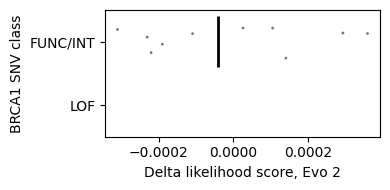

In [20]:
plt.figure(figsize=(4, 2))

# Plot stripplot of distributions
p = sns.stripplot(
    data=brca1_first_1000_df,
    x='delta score',
    y='class',
    hue='class',
    order=['FUNC/INT', 'LOF'],
    palette=['#777777', 'C3'],
    size=2,
    jitter=0.3,
)

# Mark medians from each distribution
sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'visible': False},
            medianprops={'color': 'k', 'ls': '-', 'lw': 2},
            whiskerprops={'visible': False},
            zorder=10,
            x="delta score",
            y="class",
            data=brca1_first_1000_df,
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=p)
plt.xlabel('Delta likelihood score, Evo 2')
plt.ylabel('BRCA1 SNV class')
plt.tight_layout()
plt.show()

We can also calculate the area under the receiver operating characteristic curve (AUROC) of this zero-shot prediction method.

In [ ]:
# Calculate AUROC of zero-shot predictions
y_true = (brca1_first_1000_df['class'] == 'LOF')
auroc = roc_auc_score(y_true, -brca1_first_1000_df['delta score'])

print(f'Zero-shot prediction AUROC: {auroc:.2}')